In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import random
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)

print("Working directory:", os.getcwd())
print("\nCSV files available:")
for f in os.listdir('.'):
    if f.endswith('.csv'):
        print(f"  - {f}")

Working directory: /Users/leonard/Downloads/archive (1)

CSV files available:
  - sample_submission_pzljTaX.csv
  - train_0irEZ2H.csv
  - test_nfaJ3J5.csv


In [3]:

def RMSLE(actual, predicted):
    predicted = np.array([np.log(np.abs(x+1.0)) for x in predicted])
    actual = np.array([np.log(np.abs(x+1.0)) for x in actual])
    log_err = actual-predicted
    return 1000*np.sqrt(np.mean(log_err**2))


In [4]:
# Thêm cell này sau cell define RMSLE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(actual, predicted):
    """Calculate comprehensive metrics"""
    # Basic metrics
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Median Absolute Error
    median_ae = np.median(np.abs(actual - predicted))
    
    # RMSLE (already defined)
    rmsle = RMSLE(actual, predicted)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Median_AE': median_ae,
        'RMSLE': rmsle
    }

def print_metrics(metrics_dict, fold=None):
    """Pretty print metrics"""
    if fold:
        print(f"\n📊 Metrics for Fold {fold}:")
    else:
        print("\n📊 Overall Metrics:")
    print("="*50)
    for metric, value in metrics_dict.items():
        if metric == 'R2':
            print(f"  {metric:15s}: {value:.4f}")
        elif metric == 'MAPE':
            print(f"  {metric:15s}: {value:.2f}%")
        else:
            print(f"  {metric:15s}: {value:.2f}")
    print("="*50)

In [5]:
print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

train = pd.read_csv('train_0irEZ2H.csv')
test = pd.read_csv('test_nfaJ3J5.csv')
submit = pd.read_csv('sample_submission_pzljTaX.csv')

print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Submit shape: {submit.shape}")

print("\nTrain head:")
print(train.head(2))


LOADING DATA

Train shape: (150150, 9)
Test shape: (13860, 8)
Submit shape: (13860, 2)

Train head:
   record_ID      week  store_id  sku_id  total_price  base_price  \
0          1  17/01/11      8091  216418      99.0375    111.8625   
1          2  17/01/11      8091  216419      99.0375     99.0375   

   is_featured_sku  is_display_sku  units_sold  
0                0               0          20  
1                0               0          28  


In [6]:

print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

# Create store_sku identifier
train['store_sku'] = (train['store_id'].astype('str') + "_" + train['sku_id'].astype('str'))
test['store_sku'] = (test['store_id'].astype('str') + "_" + test['sku_id'].astype('str'))

print(f"\nUnique store_sku in train: {train['store_sku'].nunique()}")
print(f"Unique store_sku in test: {test['store_sku'].nunique()}")

# Check for missing values in total_price
print(f"\nMissing values in train total_price: {train['total_price'].isnull().sum()}")

# Fill missing total_price with base_price
train['total_price'] = train['total_price'].fillna(train['base_price'])

# Append train and test (UPDATED: use pd.concat instead of append)
test['units_sold'] = -1
data = pd.concat([train, test], ignore_index=True)

print(f"\nCombined data shape: {data.shape}")



DATA PREPROCESSING

Unique store_sku in train: 1155
Unique store_sku in test: 1155

Missing values in train total_price: 1

Combined data shape: (164010, 10)


In [7]:

print("\n" + "="*60)
print("FEATURE ENGINEERING - PRICE")
print("="*60)

train['diff'] = train['base_price'] - train['total_price']
train['relative_diff_base'] = train['diff']/train['base_price']
train['relative_diff_total'] = train['diff']/train['total_price']

test['diff'] = test['base_price'] - test['total_price']
test['relative_diff_base'] = test['diff']/test['base_price']
test['relative_diff_total'] = test['diff']/test['total_price']

print("\nPrice features correlation with target:")
cols = ['base_price', 'total_price', 'diff', 'relative_diff_base', 'relative_diff_total',
        'is_featured_sku', 'is_display_sku', 'units_sold']
print(train[cols].corr()['units_sold'].sort_values(ascending=False))


FEATURE ENGINEERING - PRICE

Price features correlation with target:
units_sold             1.000000
relative_diff_total    0.365690
relative_diff_base     0.364841
is_display_sku         0.362662
is_featured_sku        0.337751
diff                   0.278283
base_price            -0.140032
total_price           -0.235634
Name: units_sold, dtype: float64


In [8]:
print("="*60)
print("CATEGORICAL ENCODING")
print("="*60)

from category_encoders import MEstimateEncoder

# Convert to categorical FIRST
train['store_id'] = train['store_id'].astype('category')
train['sku_id'] = train['sku_id'].astype('category')
test['store_id'] = test['store_id'].astype('category')
test['sku_id'] = test['sku_id'].astype('category')

# Encode store_id
encoder = MEstimateEncoder()
encoder.fit(train['store_id'], train['units_sold'])
train['store_encoded'] = encoder.transform(train['store_id'])
test['store_encoded'] = encoder.transform(test['store_id'])

# Encode sku_id
encoder.fit(train['sku_id'], train['units_sold'])
train['sku_encoded'] = encoder.transform(train['sku_id'])
test['sku_encoded'] = encoder.transform(test['sku_id'])

print("✓ Encoding completed!")
print(f"  store_encoded range: [{train['store_encoded'].min():.2f}, {train['store_encoded'].max():.2f}]")
print(f"  sku_encoded range: [{train['sku_encoded'].min():.2f}, {train['sku_encoded'].max():.2f}]")

CATEGORICAL ENCODING
✓ Encoding completed!
  store_encoded range: [20.29, 118.25]
  sku_encoded range: [15.51, 98.89]


In [9]:

print("\n" + "="*60)
print("DATETIME FEATURE EXTRACTION")
print("="*60)

from datetime import datetime, timedelta

# Convert week to datetime
train['week'] = pd.to_datetime(train['week'], format='%d/%m/%y')
test['week'] = pd.to_datetime(test['week'], format='%d/%m/%y')

# Create weekend_date
train['weekend_date'] = train['week'] + timedelta(days=6)
test['weekend_date'] = test['week'] + timedelta(days=6)

def extract_time_features(df):
    start_date = datetime(2011, 1, 17)
    
    print('  - Extracting basic features for week start date')
    df['year'] = df['week'].dt.year
    df['date'] = df['week'].dt.day
    df['month'] = df['week'].dt.month
    df['weekday'] = df['week'].dt.dayofweek
    df['weeknum'] = df['week'].dt.isocalendar().week  # UPDATED: dt.weekofyear is deprecated
    df['week_serial'] = (df['week'] - start_date).dt.total_seconds() / (86400 * 7)
    
    print('  - Extracting basic features for week end date')
    df['end_year'] = df['weekend_date'].dt.year
    df['end_date'] = df['weekend_date'].dt.day
    df['end_month'] = df['weekend_date'].dt.month
    df['end_weekday'] = df['weekend_date'].dt.dayofweek
    df['end_weeknum'] = df['weekend_date'].dt.isocalendar().week  # UPDATED
    df['end_week_serial'] = (df['weekend_date'] - start_date).dt.total_seconds() / (86400 * 7)
    
    return df

train = extract_time_features(train)
test = extract_time_features(test)

print("\nDatetime features extracted!")


DATETIME FEATURE EXTRACTION
  - Extracting basic features for week start date
  - Extracting basic features for week end date
  - Extracting basic features for week start date
  - Extracting basic features for week end date

Datetime features extracted!


In [10]:

print("\n" + "="*60)
print("PREPARING FEATURES")
print("="*60)

# Define feature columns
cols_to_use = [
    'base_price', 'total_price', 'diff', 'relative_diff_base', 'relative_diff_total',
    'is_featured_sku', 'is_display_sku', 'store_encoded', 'sku_encoded',
    'store_id', 'sku_id',
    'date', 'end_week_serial', 'month', 'week_serial', 'year', 'weekday', 
    'weeknum', 'end_weekday', 'end_month', 'end_weeknum', 'end_date', 'end_year'
]

# Categorical columns for LightGBM
cat_cols = ['is_featured_sku', 'is_display_sku', 'store_id', 'sku_id']

# Encode time features
new_feat = ['date', 'end_week_serial', 'month', 'week_serial', 'year', 
            'weekday', 'weeknum', 'end_weekday', 'end_month', 'end_weeknum', 
            'end_date', 'end_year']

encoder = MEstimateEncoder()
encoder.fit(train[new_feat], train['units_sold'])
train[new_feat] = encoder.transform(train[new_feat])
test[new_feat] = encoder.transform(test[new_feat])

print(f"\nTotal features: {len(cols_to_use)}")
print(f"Categorical features: {len(cat_cols)}")



PREPARING FEATURES

Total features: 23
Categorical features: 4


In [11]:
print("\n" + "="*60)
print("MODEL TRAINING - LIGHTGBM WITH 10-FOLD CV")
print("="*60)

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import time
import joblib
import os

# Create directory for models
os.makedirs('models', exist_ok=True)
os.makedirs('encoders', exist_ok=True)

def runLGB(Xtrain, ytrain, Xval, yval, cat_cols, Xtest=None):
    params = {
        'boosting_type': 'dart',
        'objective': 'regression',
        'metric': 'l1',
        'learning_rate': 0.5,
        'verbose': -1,
        'min_data_in_leaf': 15,
        'bagging_fraction': 0.7,
        'feature_fraction': 0.7,
        'bagging_seed': 50
    }
    
    n_estimators = 575
    early_stopping_rounds = 30
    
    d_train = lgb.Dataset(Xtrain.copy(), label=np.log1p(ytrain.copy()), 
                         categorical_feature=cat_cols, free_raw_data=False)
    d_valid = lgb.Dataset(Xval.copy(), label=np.log1p(yval.copy()), 
                         categorical_feature=cat_cols, free_raw_data=False)
    
    model = lgb.train(params, d_train, n_estimators,
                      valid_sets=[d_train, d_valid],
                      valid_names=['train', 'valid'],
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False),
                          lgb.log_evaluation(period=125)
                      ])
    
    preds = model.predict(Xval, num_iteration=model.best_iteration)
    
    # Calculate multiple metrics
    actual = yval['units_sold'].values
    predicted = np.exp(preds)
    
    metrics = calculate_metrics(actual, predicted)
    
    preds_test = np.exp(model.predict(Xtest, num_iteration=model.best_iteration))
    return preds, metrics, preds_test, model, predicted, actual

# Prepare data
X = train[cols_to_use]
y = train[['units_sold']]
Xtest = test[cols_to_use]

# 10-Fold Cross Validation
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=22)

preds_buff = 0
metrics_buff = []
all_predictions = []
all_actuals = []
models = []

print(f"\nRunning {n_splits}-fold cross validation...\n")

for fold_idx, (dev_index, val_index) in enumerate(kf.split(X, y['units_sold']), 1):
    start = time.time()
    print(f"Fold {fold_idx}/{n_splits}")
    
    Xtrain, Xval = X.iloc[dev_index], X.iloc[val_index]
    ytrain, yval = y.iloc[dev_index], y.iloc[val_index]
    
    pred_val, metrics, pred_test, model, predicted, actual = runLGB(
        Xtrain, ytrain, Xval, yval, cat_cols, Xtest
    )
    
    # Store results
    preds_buff += pred_test
    metrics_buff.append(metrics)
    all_predictions.extend(predicted)
    all_actuals.extend(actual)
    models.append(model)
    
    # Save model
    model.save_model(f'models/model_fold_{fold_idx-1}.txt')
    
    # Print metrics
    print_metrics(metrics, fold=fold_idx)
    print(f"  ⏱️  Time: {time.time()-start:.2f}s\n")

preds_buff /= n_splits

# Calculate overall metrics
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

overall_metrics = calculate_metrics(
    np.array(all_actuals), 
    np.array(all_predictions)
)
print_metrics(overall_metrics)

# Print mean metrics across folds
print("\n📊 Mean Metrics Across Folds:")
print("="*50)
for key in metrics_buff[0].keys():
    values = [m[key] for m in metrics_buff]
    mean_val = np.mean(values)
    std_val = np.std(values)
    if key == 'MAPE':
        print(f"  {key:15s}: {mean_val:.2f}% ± {std_val:.2f}%")
    else:
        print(f"  {key:15s}: {mean_val:.2f} ± {std_val:.2f}")
print("="*50)

print(f"\n✓ Saved {len(models)} models to 'models/' directory")


MODEL TRAINING - LIGHTGBM WITH 10-FOLD CV

Running 10-fold cross validation...

Fold 1/10
[125]	train's l1: 0.257023	valid's l1: 0.264312
[250]	train's l1: 0.239156	valid's l1: 0.251461
[375]	train's l1: 0.228633	valid's l1: 0.24484
[500]	train's l1: 0.219014	valid's l1: 0.240809

📊 Metrics for Fold 1:
  RMSE           : 21.00
  MAE            : 10.45
  MAPE           : 30.66%
  R2             : 0.8793
  Median_AE      : 6.33
  RMSLE          : 327.46
  ⏱️  Time: 12.92s

Fold 2/10
[125]	train's l1: 0.258104	valid's l1: 0.265294
[250]	train's l1: 0.2385	valid's l1: 0.250842
[375]	train's l1: 0.228557	valid's l1: 0.244558
[500]	train's l1: 0.218834	valid's l1: 0.240665

📊 Metrics for Fold 2:
  RMSE           : 20.06
  MAE            : 10.50
  MAPE           : 30.36%
  R2             : 0.8883
  Median_AE      : 6.56
  RMSLE          : 324.20
  ⏱️  Time: 12.88s

Fold 3/10
[125]	train's l1: 0.257859	valid's l1: 0.267696
[250]	train's l1: 0.237704	valid's l1: 0.251122
[375]	train's l1: 0.22


GENERATING VISUALIZATIONS
✓ Saved visualization: model_performance.png


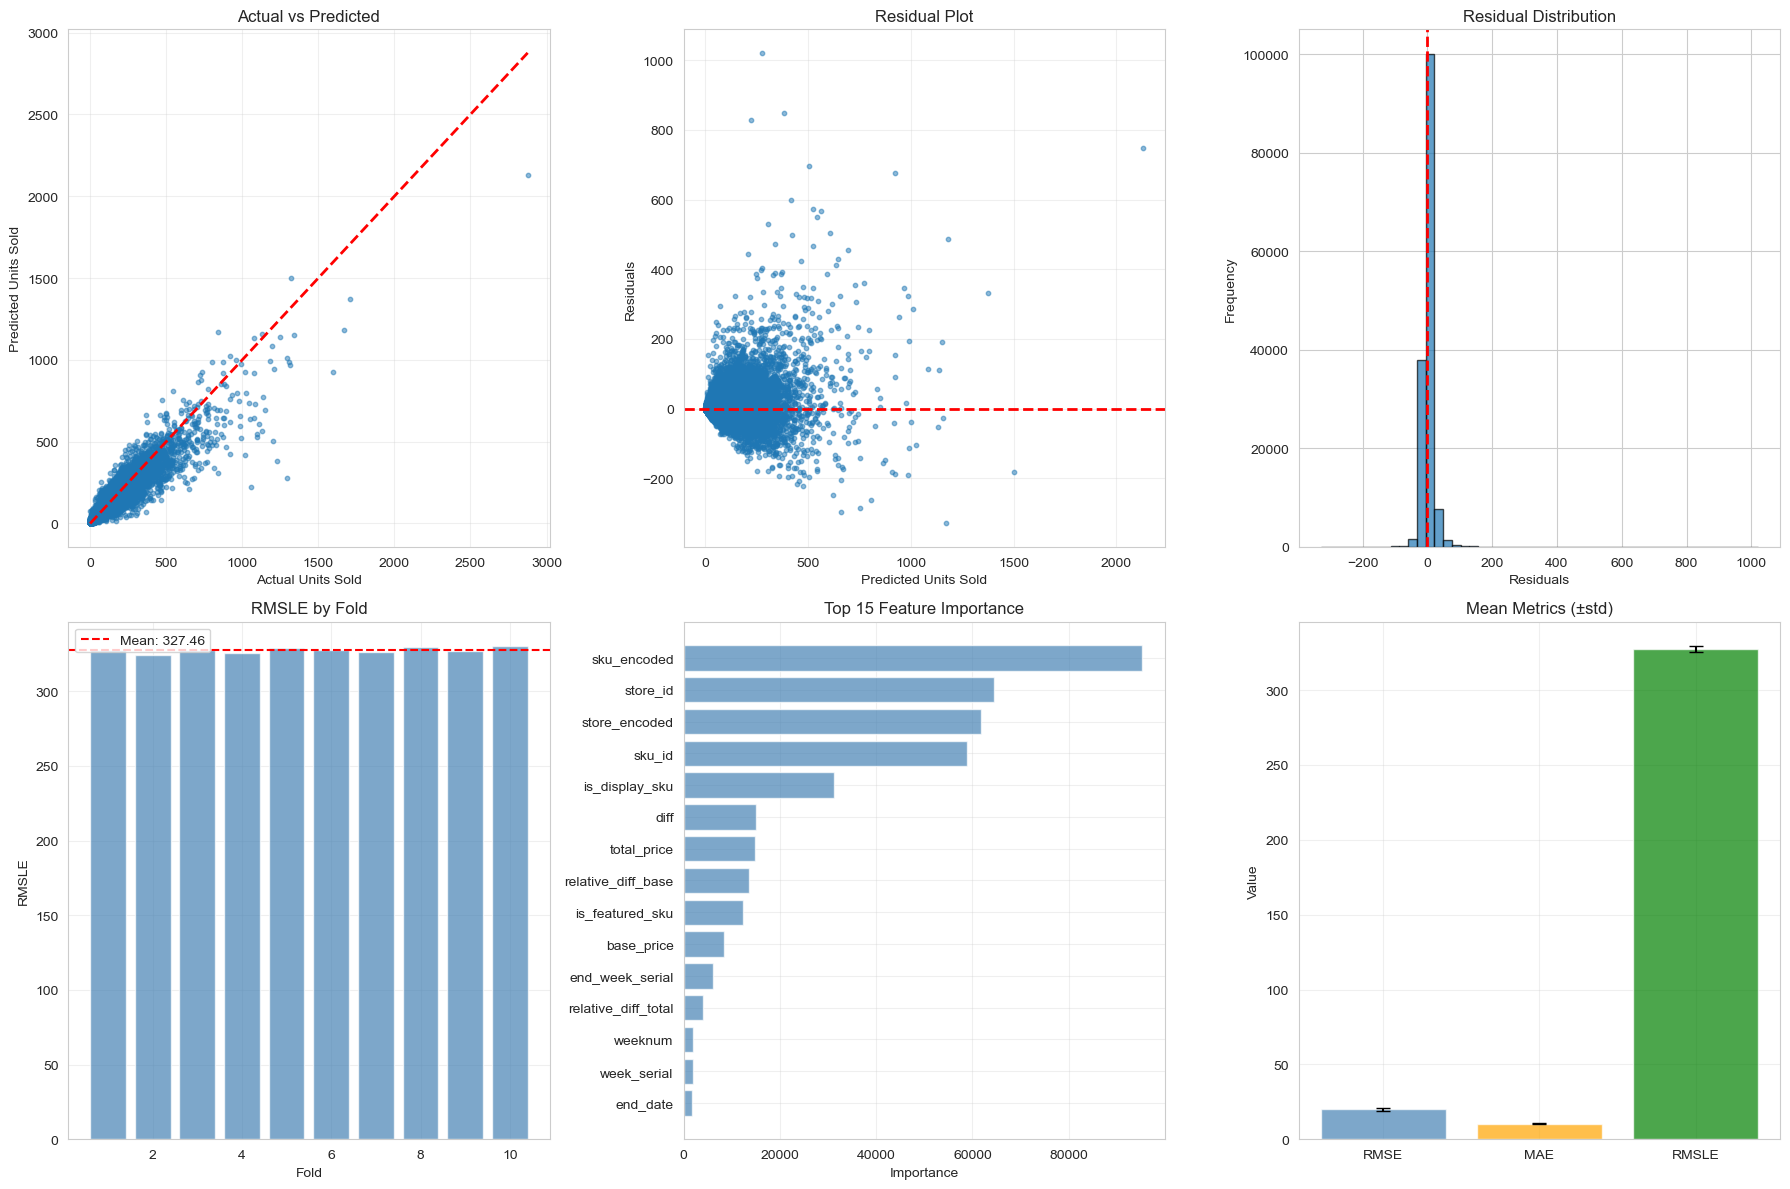


✓ Visualizations complete!


In [14]:
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(all_actuals, all_predictions, alpha=0.5, s=10)
axes[0, 0].plot([0, max(all_actuals)], [0, max(all_actuals)], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Units Sold')
axes[0, 0].set_ylabel('Predicted Units Sold')
axes[0, 0].set_title('Actual vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals
residuals = np.array(all_actuals) - np.array(all_predictions)
axes[0, 1].scatter(all_predictions, residuals, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Units Sold')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual Distribution
axes[0, 2].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Residuals')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Residual Distribution')
axes[0, 2].axvline(x=0, color='r', linestyle='--', lw=2)

# 4. RMSLE by Fold
fold_rmsle = [m['RMSLE'] for m in metrics_buff]
axes[1, 0].bar(range(1, len(fold_rmsle)+1), fold_rmsle, color='steelblue', alpha=0.7)
axes[1, 0].axhline(y=np.mean(fold_rmsle), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(fold_rmsle):.2f}')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('RMSLE')
axes[1, 0].set_title('RMSLE by Fold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Feature Importance (from last model)
importance = models[-1].feature_importance(importance_type='gain')
feature_importance = pd.DataFrame({
    'feature': cols_to_use,
    'importance': importance
}).sort_values('importance', ascending=False).head(15)

axes[1, 1].barh(feature_importance['feature'][::-1], 
                feature_importance['importance'][::-1], 
                color='steelblue', alpha=0.7)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 15 Feature Importance')
axes[1, 1].grid(True, alpha=0.3)

# 6. Metrics Comparison
metrics_names = list(metrics_buff[0].keys())
metrics_values = {name: [m[name] for m in metrics_buff] for name in metrics_names}

# Plot RMSE, MAE, RMSLE
metrics_to_plot = ['RMSE', 'MAE', 'RMSLE']
x_pos = np.arange(len(metrics_to_plot))
means = [np.mean(metrics_values[m]) for m in metrics_to_plot]
stds = [np.std(metrics_values[m]) for m in metrics_to_plot]

axes[1, 2].bar(x_pos, means, yerr=stds, alpha=0.7, 
               color=['steelblue', 'orange', 'green'],
               capsize=5)
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_to_plot)
axes[1, 2].set_ylabel('Value')
axes[1, 2].set_title('Mean Metrics (±std)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: model_performance.png")
plt.show()

print("\n✓ Visualizations complete!")

In [15]:
print("\n" + "="*60)
print("SAVING ENCODERS & CONFIGURATION")
print("="*60)

import os
import joblib
import json
from category_encoders import MEstimateEncoder

# Create directories if not exist
os.makedirs('encoders', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Save store encoder
store_encoder = MEstimateEncoder()
store_encoder.fit(train['store_id'], train['units_sold'])
joblib.dump(store_encoder, 'encoders/store_encoder.pkl')
print("✓ Saved store_encoder.pkl")

# Save SKU encoder
sku_encoder = MEstimateEncoder()
sku_encoder.fit(train['sku_id'], train['units_sold'])
joblib.dump(sku_encoder, 'encoders/sku_encoder.pkl')
print("✓ Saved sku_encoder.pkl")

# Save time features encoder
time_encoder = MEstimateEncoder()
time_encoder.fit(train[new_feat], train['units_sold'])
joblib.dump(time_encoder, 'encoders/time_encoder.pkl')
print("✓ Saved time_encoder.pkl")

# Save feature configuration
config = {
    'feature_columns': cols_to_use,
    'categorical_columns': cat_cols,
    'time_features': new_feat,
    'n_folds': n_splits,
    'base_date': '2011-01-17',
    'model_type': 'LightGBM_DART',
    'target_transform': 'log1p',
    'n_estimators': 575,
    'learning_rate': 0.5
}

with open('models/config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("✓ Saved config.json")

print("\n📦 All encoders and config saved!")
print(f"   Directory: {os.getcwd()}")
print(f"   Files:")
print(f"     - encoders/store_encoder.pkl")
print(f"     - encoders/sku_encoder.pkl")
print(f"     - encoders/time_encoder.pkl")
print(f"     - models/config.json")


SAVING ENCODERS & CONFIGURATION
✓ Saved store_encoder.pkl
✓ Saved sku_encoder.pkl
✓ Saved time_encoder.pkl
✓ Saved config.json

📦 All encoders and config saved!
   Directory: /Users/leonard/Downloads/archive (1)
   Files:
     - encoders/store_encoder.pkl
     - encoders/sku_encoder.pkl
     - encoders/time_encoder.pkl
     - models/config.json


In [16]:
# API Helper Functions - Copy this for your API
print("\n" + "="*60)
print("API HELPER FUNCTIONS")
print("="*60)

def load_models_for_api():
    """
    Load all trained models and encoders for API
    Usage in your API:
        models, encoders, config = load_models_for_api()
    """
    import lightgbm as lgb
    import joblib
    import json
    
    # Load models
    models = []
    for i in range(10):
        model = lgb.Booster(model_file=f'models/model_fold_{i}.txt')
        models.append(model)
    
    # Load encoders
    encoders = {
        'store': joblib.load('encoders/store_encoder.pkl'),
        'sku': joblib.load('encoders/sku_encoder.pkl'),
        'time': joblib.load('encoders/time_encoder.pkl')
    }
    
    # Load config
    with open('models/config.json', 'r') as f:
        config = json.load(f)
    
    print(f"✓ Loaded {len(models)} models")
    print(f"✓ Loaded {len(encoders)} encoders")
    print(f"✓ Loaded configuration")
    
    return models, encoders, config

# Test loading
try:
    models_api, encoders_api, config_api = load_models_for_api()
    print("\n✅ All files can be loaded successfully for API!")
    print("\nConfig preview:")
    print(json.dumps(config_api, indent=2))
except Exception as e:
    print(f"\n❌ Error loading files: {e}")


API HELPER FUNCTIONS
✓ Loaded 10 models
✓ Loaded 3 encoders
✓ Loaded configuration

✅ All files can be loaded successfully for API!

Config preview:
{
  "feature_columns": [
    "base_price",
    "total_price",
    "diff",
    "relative_diff_base",
    "relative_diff_total",
    "is_featured_sku",
    "is_display_sku",
    "store_encoded",
    "sku_encoded",
    "store_id",
    "sku_id",
    "date",
    "end_week_serial",
    "month",
    "week_serial",
    "year",
    "weekday",
    "weeknum",
    "end_weekday",
    "end_month",
    "end_weeknum",
    "end_date",
    "end_year"
  ],
  "categorical_columns": [
    "is_featured_sku",
    "is_display_sku",
    "store_id",
    "sku_id"
  ],
  "time_features": [
    "date",
    "end_week_serial",
    "month",
    "week_serial",
    "year",
    "weekday",
    "weeknum",
    "end_weekday",
    "end_month",
    "end_weeknum",
    "end_date",
    "end_year"
  ],
  "n_folds": 10,
  "base_date": "2011-01-17",
  "model_type": "LightGBM_DART",
  